In [35]:
%pip install kaggle opencv-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [36]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import json

import random
import os
from PIL import Image

from tensorflow import keras as K

## Carga del Dataset


In [37]:
DS_PATH = "ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"

# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


In [38]:
def resize_and_pad_image(image, img_size):
    if image.mode in ("RGBA", "LA"):
        # Create a white background image (255, 255, 255 = white)
        white_background = Image.new("RGB", image.size, (255, 255, 255))
        # Paste the image onto the white background, using the alpha channel as a mask
        white_background.paste(image.convert("RGB"), mask=image.split()[-1])
        image = white_background  # Update image to have white background

    original_width, original_height = image.size
    aspect_ratio = original_width / original_height

    # Calculate new dimensions based on aspect ratio
    if original_width > original_height:
        new_width = img_size[0]
        new_height = int(img_size[0] / aspect_ratio)
    else:
        new_height = img_size[1]
        new_width = int(img_size[1] * aspect_ratio)

    # Resize the image with high-quality downsampling
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new blank image with the target size (white padding)
    padded_image = Image.new("RGB", img_size, (255, 255, 255))

    # Calculate position to paste the resized image onto the padded image
    x_offset = (img_size[0] - resized_image.size[0]) // 2
    y_offset = (img_size[1] - resized_image.size[1]) // 2

    # Paste the resized image onto the padded image
    padded_image.paste(resized_image, (x_offset, y_offset))

    return padded_image

In [39]:
# import cv2
from pathlib import Path

valid_img_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

# Resolucion de imagenes de 128 x 128
img_res = 128

X = []
y = []
labelNames = {}

print("[INFO]: Leyendo imagenes de poses")
for id, pose in enumerate(df.itertuples()):
    print(f"[INFO]: Procesando pose: {pose.sanskrit_name} / {pose.english_name}")
    labelNames[id] = pose.english_name

    # Obtengo la carpeta de imagenes de la pose
    folder = f"{DS_PATH}/{pose.sanskrit_name}"

    for file in os.listdir(folder):
        img_path = f"{folder}/{file}"

        if Path(img_path).suffix.lower() not in valid_img_extensions:
            print(f"[WARN]: Formato {img_path} no valido")
            continue

        img = Image.open(img_path)

        img = resize_and_pad_image(img, (img_res, img_res))

        X.append(img)
        y.append(id)


# Convertir a numpy array
X = np.array(X)
y = np.array(y)

[INFO]: Leyendo imagenes de poses
[INFO]: Procesando pose: Navasana / Boat
[INFO]: Procesando pose: Ardha Navasana / Half-Boat
[INFO]: Procesando pose: Dhanurasana / Bow
[INFO]: Procesando pose: Setu Bandha Sarvangasana / Bridge
[INFO]: Procesando pose: Baddha Konasana / Butterfly
[INFO]: Procesando pose: Ustrasana / Camel
[INFO]: Procesando pose: Marjaryasana / Cat
[INFO]: Procesando pose: Bitilasana / Cow
[INFO]: Procesando pose: Utkatasana / Chair
[INFO]: Procesando pose: Balasana / Child's Pose


/home/emasuriano/miniconda3/envs/myenv/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO]: Procesando pose: Sivasana / Corpse
[INFO]: Procesando pose: Alanasana / Crescent Lunge
[INFO]: Procesando pose: Bakasana / Crow
[INFO]: Procesando pose: Ardha Pincha Mayurasana / Dolphin
[INFO]: Procesando pose: Adho Mukha Svanasana / Downward-Facing Dog
[INFO]: Procesando pose: Garudasana / Eagle
[INFO]: Procesando pose: Utthita Hasta Padangusthasana / Extended Hand to Toe
[INFO]: Procesando pose: Utthita Parsvakonasana / Extended Side Angle
[INFO]: Procesando pose: Pincha Mayurasana / Forearm Stand
[INFO]: Procesando pose: Uttanasana / Forward Bend with Shoulder Opener
[INFO]: Procesando pose: Ardha Chandrasana / Half-Moon
[INFO]: Procesando pose: Adho Mukha Vrksasana / Handstand
[INFO]: Procesando pose: Anjaneyasana / Low Lunge
[INFO]: Procesando pose: Supta Kapotasana / Pigeon
[INFO]: Procesando pose: Eka Pada Rajakapotasana / King Pigeon
[INFO]: Procesando pose: Phalakasana / Plank
[INFO]: Procesando pose: Halasana / Plow
[INFO]: Procesando pose: Parsvottanasana / Pyramid


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Output the results
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Check the class distribution
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

X_train: (1978, 128, 128, 3)
y_train: (1978,)
X_test: (849, 128, 128, 3)
y_test: (849,)
Class distribution in y_train: [13  9 38 46 57 67 39 66 57 55 14 13 59 38 52 59 45 48 30 50 41 45 50  9
 37 46 50 30 10 43 54 67 51 56 43 29 51 50  8 12 48 16 48 44 42 48 52 43]
Class distribution in y_test: [ 5  4 16 20 24 29 17 28 24 24  6  5 25 16 22 26 19 21 13 21 18 20 21  4
 16 20 21 13  4 19 23 29 22 24 19 12 22 21  4  5 20  7 21 19 18 21 22 19]


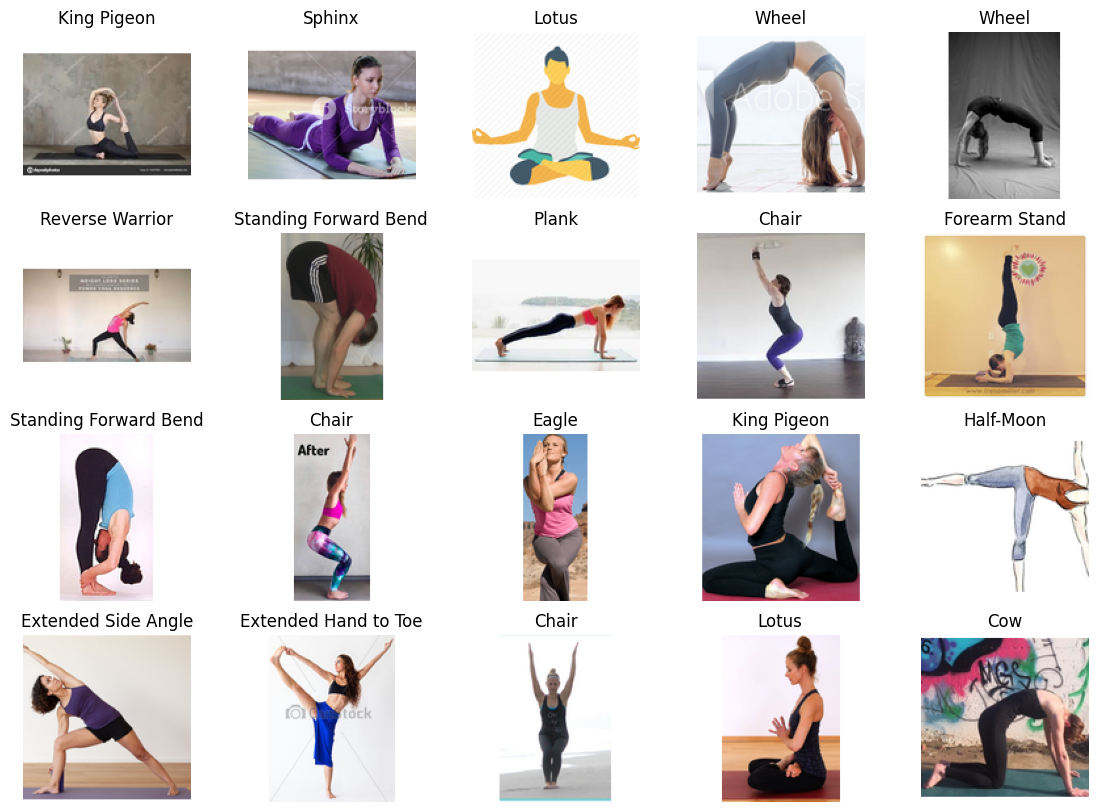

In [41]:
fig = plt.figure(figsize=(14, 10))

samples = np.random.randint(0, len(X_train), 20)

for i, img_idx in enumerate(samples):
    fig.add_subplot(4, 5, i + 1)

    plt.imshow(X_train[img_idx])
    plt.title(labelNames[y_train[img_idx]])
    plt.axis("off")

plt.show()

## Normalization

In [42]:
from sklearn.preprocessing import LabelBinarizer

# Img normalization
X_train_n = X_train / 255
X_test_n = X_test / 255

# One hot encoding for labels
lb = LabelBinarizer()
y_train_n = lb.fit_transform(y_train)
y_test_n = lb.transform(y_test)

## Data Augmentation

In [43]:
datagen = K.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,  # Zoom in/out by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest",  # Fill mode to avoid clipping of images (reflect, wrap, constant)
    validation_split=0.3,
)

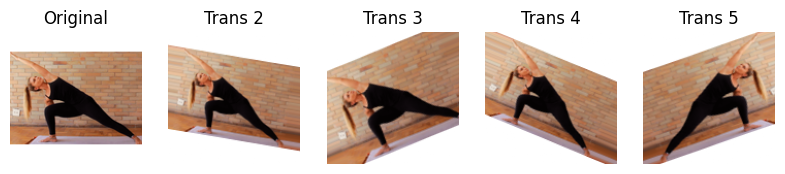

In [44]:
sample = random.randint(0, len(X_train_n))

img_orig = X_train_n[sample]

fig = plt.figure(figsize=(16, 10))

fig.add_subplot(4, 8, 1)
plt.imshow(img_orig)
plt.title("Original")
plt.axis("off")

# # Show transformations
# fig = plt.figure(figsize=(8, 8))
for n in range(2, 6):
    fig.add_subplot(4, 8, n)
    img = datagen.random_transform(img_orig)

    plt.imshow(img)
    plt.title(f"Trans {n}")
    plt.axis("off")

plt.show()

## Model definition

> Reemplazar esto por el modelo que quieran entrenar! ⚠️ 

In [45]:
input_shape = (img_res, img_res, 3)

# Pre-trained
base_model = K.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# transfer-learning mode
base_model.trainable = False

# Entry layer
model = K.models.Sequential()
model.add(K.layers.Input(shape=input_shape))

# Add base model
model.add(base_model)

# Example of hidden layer
model.add(
    K.layers.Dense(
        256,
        activation="relu",
        kernel_regularizer=K.regularizers.l2(0.001),
    )
)
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dropout(0.5))

# Output
model.add(K.layers.GlobalAveragePooling2D())
model.add(K.layers.Dense(len(labelNames), activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.Adam(
        learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    ),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dense_4 (Dense)             (None, 4, 4, 256)         131328    
                                                                 
 batch_normalization_2 (Bat  (None, 4, 4, 256)         1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0         
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 48)               

In [46]:
train_generator = datagen.flow(X_train_n, y_train_n, batch_size=64, subset="training")
validation_generator = datagen.flow(
    X_train_n, y_train_n, batch_size=64, subset="validation"
)

early_stopping = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    mode="min",
    restore_best_weights=True,
)

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
)

[INFO]: Entrenando la red...
Epoch 1/100
11/11 [==============================] - 5s 361ms/step - loss: 4.2429 - accuracy: 0.0368 - val_loss: 4.2771 - val_accuracy: 0.0304
Epoch 2/100
11/11 [==============================] - 4s 373ms/step - loss: 3.8003 - accuracy: 0.1220 - val_loss: 4.1581 - val_accuracy: 0.0472
Epoch 3/100
11/11 [==============================] - 3s 299ms/step - loss: 3.4596 - accuracy: 0.2224 - val_loss: 4.0481 - val_accuracy: 0.0607
Epoch 4/100
11/11 [==============================] - 3s 302ms/step - loss: 3.1894 - accuracy: 0.2968 - val_loss: 3.9397 - val_accuracy: 0.0894
Epoch 5/100
11/11 [==============================] - 3s 308ms/step - loss: 2.9594 - accuracy: 0.3531 - val_loss: 3.8189 - val_accuracy: 0.1096
Epoch 6/100
11/11 [==============================] - 3s 308ms/step - loss: 2.7712 - accuracy: 0.4007 - val_loss: 3.7115 - val_accuracy: 0.1366
Epoch 7/100
11/11 [==============================] - 3s 301ms/step - loss: 2.6128 - accuracy: 0.4332 - val_loss: 

In [49]:
from sklearn.metrics import classification_report

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=64)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
14/14 [==============================] - 0s 33ms/step
                                   precision    recall  f1-score   support

                             Boat       0.60      0.60      0.60         5
                        Half-Boat       0.33      0.25      0.29         4
                              Bow       1.00      0.81      0.90        16
                           Bridge       0.94      0.75      0.83        20
                        Butterfly       0.59      0.71      0.64        24
                            Camel       0.76      0.76      0.76        29
                              Cat       0.50      0.47      0.48        17
                              Cow       0.86      0.64      0.73        28
                            Chair       0.51      0.88      0.65        24
                     Child's Pose       0.67      0.67      0.67        24
                           Corpse       0.67      0.33      0.44         6
              

/home/emasuriano/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emasuriano/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emasuriano/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

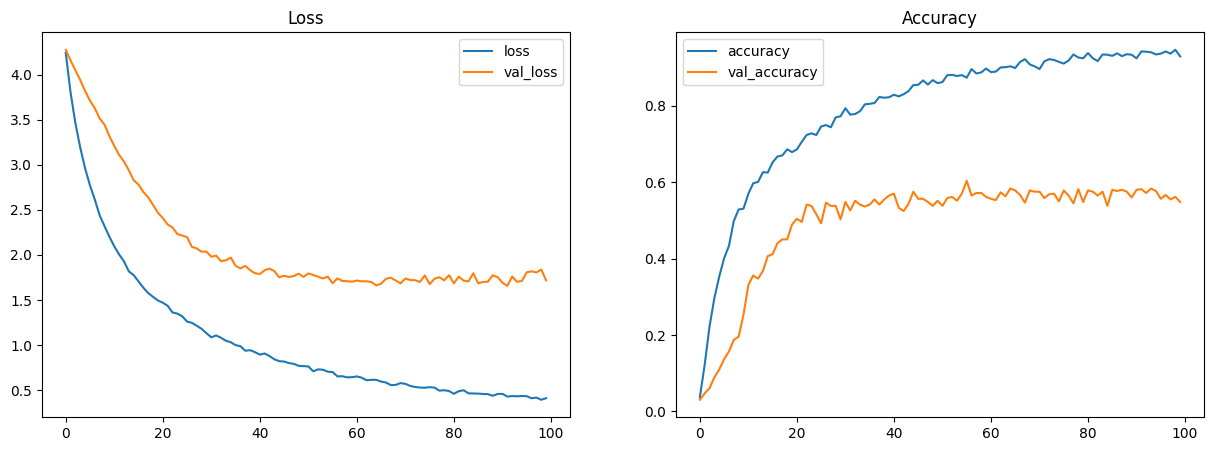

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()